In [2]:
import sys
%pip install -y -c conda-forge rdkit

Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from matplotlib import pyplot as plt

df = pd.read_csv("../data/raw/data.csv")

print(df.isna().sum())

X = df.drop("flashpoint", axis=1)
y = df["flashpoint"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df.head()

compound          0
flashpoint        0
pure substance    0
smiles            0
source            0
is_silicon        0
is_metallic       0
is_tin            0
is_acid           0
data type         0
dtype: int64


,compound,flashpoint,pure substance,smiles,source,is_silicon,is_metallic,is_tin,is_acid,data type
0,1-aminopropan-2-ol,350.15,1,CC(CN)O,pubchem,0,0,0,0,randonly selected as training point or test point
1,"1-chloro-2,4-dinitrobenzene",467.15,1,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,pubchem,0,0,0,0,randonly selected as training point or test point
2,"1,2-dichloroethane",286.15,1,C(CCl)Cl,pubchem,0,0,0,0,randonly selected as training point or test point
3,"1,2,4-trichlorobenzene",383.15,1,C1=CC(=C(C=C1Cl)Cl)Cl,pubchem,0,0,0,0,randonly selected as training point or test point
4,2-chloroacetaldehyde,361.15,1,C(C=O)Cl,pubchem,0,0,0,0,randonly selected as training point or test point


In [4]:
print(df['data type'].value_counts())

print()

print(df['source'].value_counts())

data type
randonly selected as training point or test point    13672
training data                                          582
Non-DIPPR data                                         289
test data                                              153
Name: count, dtype: int64

source
le15                     8843
pubchem                  1741
carroll11                 937
katritzky07               739
hazardous materials       364
carroll10                 292
mathieu14                 289
patel10                   234
chen14                    211
mathieu12                 210
wang11                    210
pan13                     193
pan07                      92
carroll15                  81
godinho11                  75
gelest_metal-organics      55
gelest_silanes             53
gelest_tin                 42
gelest_germanium           35
Name: count, dtype: int64


# Data Analysis and Feature Engineering Approach

Our dataset contains multiple features that have string values, we need to convert them to numerical values:

I. **SMILES strings** - These represent molecular structures and can be converted to molecular descriptors using RDKit
(RDKit is an open-source toolkit for cheminformatics and machine learning)

II. **Categorical features** - Need to be encoded using techniques like one-hot encoding or label encoding


Lets start by visualising some molecules (optional) to test some of RDKit features

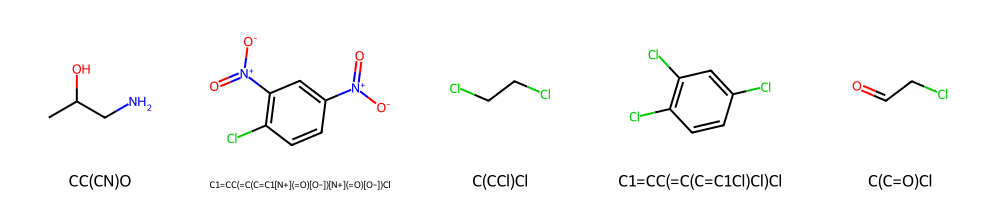

In [5]:
from rdkit.Chem import Draw

smiles_values = df['smiles'].head(5).tolist()
# Draw the first 5 SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_values]
img= Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=smiles_values)
img

**Converting smiles string to numerical values**
1. RDKit Descriptors
Descriptors are calculated physicochemical properties of molecules. RDKit provides many descriptors (e.g., molecular weight, logP, number of hydrogen bond donors, etc.).
2. Fingerprints
Fingerprints are binary or count-based vectors representing molecular substructures or patterns.

In [6]:
def calculate_molecular_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Calculate basic molecular descriptors
            descriptors = {
                'MolWt': Descriptors.MolWt(mol),                    # Molecular weight
                'LogP': Descriptors.MolLogP(mol),                   # Octanol-water partition coefficient
                'NumHDonors': Descriptors.NumHDonors(mol),          # Number of H-bond donors
                'NumHAcceptors': Descriptors.NumHAcceptors(mol),    # Number of H-bond acceptors
                'NumRotatableBonds': Descriptors.NumRotatableBonds(mol), # Number of rotatable bonds
                'NumAromaticRings': Descriptors.NumAromaticRings(mol),   # Number of aromatic rings
                'TPSA': Descriptors.TPSA(mol)                       # Topological polar surface area
            }
            
            # Calculate Morgan fingerprints (ECFP)
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fingerprint_features = np.zeros((1,))
            # Convert the fingerprint to a numpy array
            DataStructs = Chem.DataStructs
            DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_features)
            
            return pd.Series(descriptors), fingerprint_features
        else:
            return pd.Series({desc: np.nan for desc in ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 
                                                       'NumRotatableBonds', 'NumAromaticRings', 'TPSA']}), None
    except:
        return pd.Series({desc: np.nan for desc in ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 
                                                  'NumRotatableBonds', 'NumAromaticRings', 'TPSA']}), None


In [7]:
# Apply the function to the SMILES column
descriptors_df = pd.DataFrame()
fingerprints = []

# Process SMILES strings in batches
for i in range(0, len(df), 100):
    batch = df.iloc[i:i+100]
    batch_descriptors = []
    batch_fingerprints = []
    
    for smiles in batch['smiles']:
        desc, fp = calculate_molecular_descriptors(smiles)
        batch_descriptors.append(desc)
        if fp is not None:
            batch_fingerprints.append(fp)
        else:
            batch_fingerprints.append(np.zeros(1024))
            
    descriptors_df = pd.concat([descriptors_df, pd.DataFrame(batch_descriptors).reset_index(drop=True)])
    fingerprints.extend(batch_fingerprints)

descriptors_df = descriptors_df.reset_index(drop=True)

#  the fingerprints as a DataFrame
fingerprints_df = pd.DataFrame(fingerprints, columns=[f'FP_{i}' for i in range(1024)])

# Display the molecular descriptors
descriptors_df.head()

[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerator
[15:01:00] DEPRECATION WARNING: please use MorganGenerat

,MolWt,LogP,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,TPSA
0,75.111,-0.6741,2.0,2.0,1.0,0.0,46.25
1,202.553,2.1564,0.0,4.0,2.0,1.0,86.28
2,98.960,1.4640,0.0,0.0,1.0,0.0,0.00
3,181.449,3.6468,0.0,0.0,0.0,1.0,0.00
4,78.498,0.4241,0.0,1.0,1.0,0.0,17.07


Processing the categorical features

In [8]:


# 1. Handle 'data type' using one-hot encoding (just 4 data types)
encoder = OneHotEncoder(sparse_output=False, drop='first')
data_type_encoded = encoder.fit_transform(df[['data type']])
data_type_df = pd.DataFrame(data_type_encoded, columns=[f'data_type_{cat}' for cat in encoder.categories_[0][1:]])

# 2. Use label encoding for source because there are many categories (19 sources)
le = LabelEncoder()
df['source_encoded'] = le.fit_transform(df['source'])
source_df = df[['source_encoded']]

# Display encoded categorical features
print("One-hot encoded 'data type' feature:")
print(data_type_df.head())

# Show the source encoding
print("\nEncoded 'source' feature:")
source_mapping = {idx: label for idx, label in enumerate(le.classes_)}
print("\nSource encoding mapping:")
for code, source_name in source_mapping.items():
    print(f" {code} = {source_name}")

One-hot encoded 'data type' feature:
   data_type_randonly selected as training point or test point  \
0                                                1.0             
1                                                1.0             
2                                                1.0             
3                                                1.0             
4                                                1.0             

   data_type_test data  data_type_training data  
0                  0.0                      0.0  
1                  0.0                      0.0  
2                  0.0                      0.0  
3                  0.0                      0.0  
4                  0.0                      0.0  

Encoded 'source' feature:

Source encoding mapping:
 0 = carroll10
 1 = carroll11
 2 = carroll15
 3 = chen14
 4 = gelest_germanium
 5 = gelest_metal-organics
 6 = gelest_silanes
 7 = gelest_tin
 8 = godinho11
 9 = hazardous materials
 10 = katritzky07
 11 = le15
 1

Now we combine the binary data with the processed data

In [9]:
# Combine original numerical features with processed features
numerical_features = df[['is_silicon', 'is_metallic', 'is_tin', 'is_acid']]
processed_features = pd.concat([numerical_features.reset_index(drop=True), 
                               descriptors_df.reset_index(drop=True),
                               data_type_df.reset_index(drop=True),
                               source_df.reset_index(drop=True)], axis=1)

# Print the shape of the processed features
print(f"Original dataframe shape: {df.shape}")
print(f"Processed features shape: {processed_features.shape}")

# Display the first few rows of the processed features
processed_features.head()

Original dataframe shape: (14696, 11)
Processed features shape: (14696, 15)


,is_silicon,is_metallic,is_tin,is_acid,MolWt,LogP,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,TPSA,data_type_randonly selected as training point or test point,data_type_test data,data_type_training data,source_encoded
0,0,0,0,0,75.111,-0.6741,2.0,2.0,1.0,0.0,46.25,1.0,0.0,0.0,17
1,0,0,0,0,202.553,2.1564,0.0,4.0,2.0,1.0,86.28,1.0,0.0,0.0,17
2,0,0,0,0,98.960,1.4640,0.0,0.0,1.0,0.0,0.00,1.0,0.0,0.0,17
3,0,0,0,0,181.449,3.6468,0.0,0.0,0.0,1.0,0.00,1.0,0.0,0.0,17
4,0,0,0,0,78.498,0.4241,0.0,1.0,1.0,0.0,17.07,1.0,0.0,0.0,17


# Feature Engineering Summary

All the string and categorical data are successfully converted to numerical features:

1. **SMILES strings** → Molecular descriptors and fingerprints using RDKit
2. **Categorical features** → One-hot encoded or label encoded
3. **Binary features** → Already in numerical format (0/1)



In [10]:
# Update train-test split with processed features

# Replace original X with processed features
X = processed_features
y = df["flashpoint"]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save processed datasets
X_train.to_csv("../data/processed/X_train.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

print("Processed datasets saved successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Processed datasets saved successfully.
X_train shape: (11756, 15)
X_test shape: (2940, 15)


# Visualizing the relationship between features

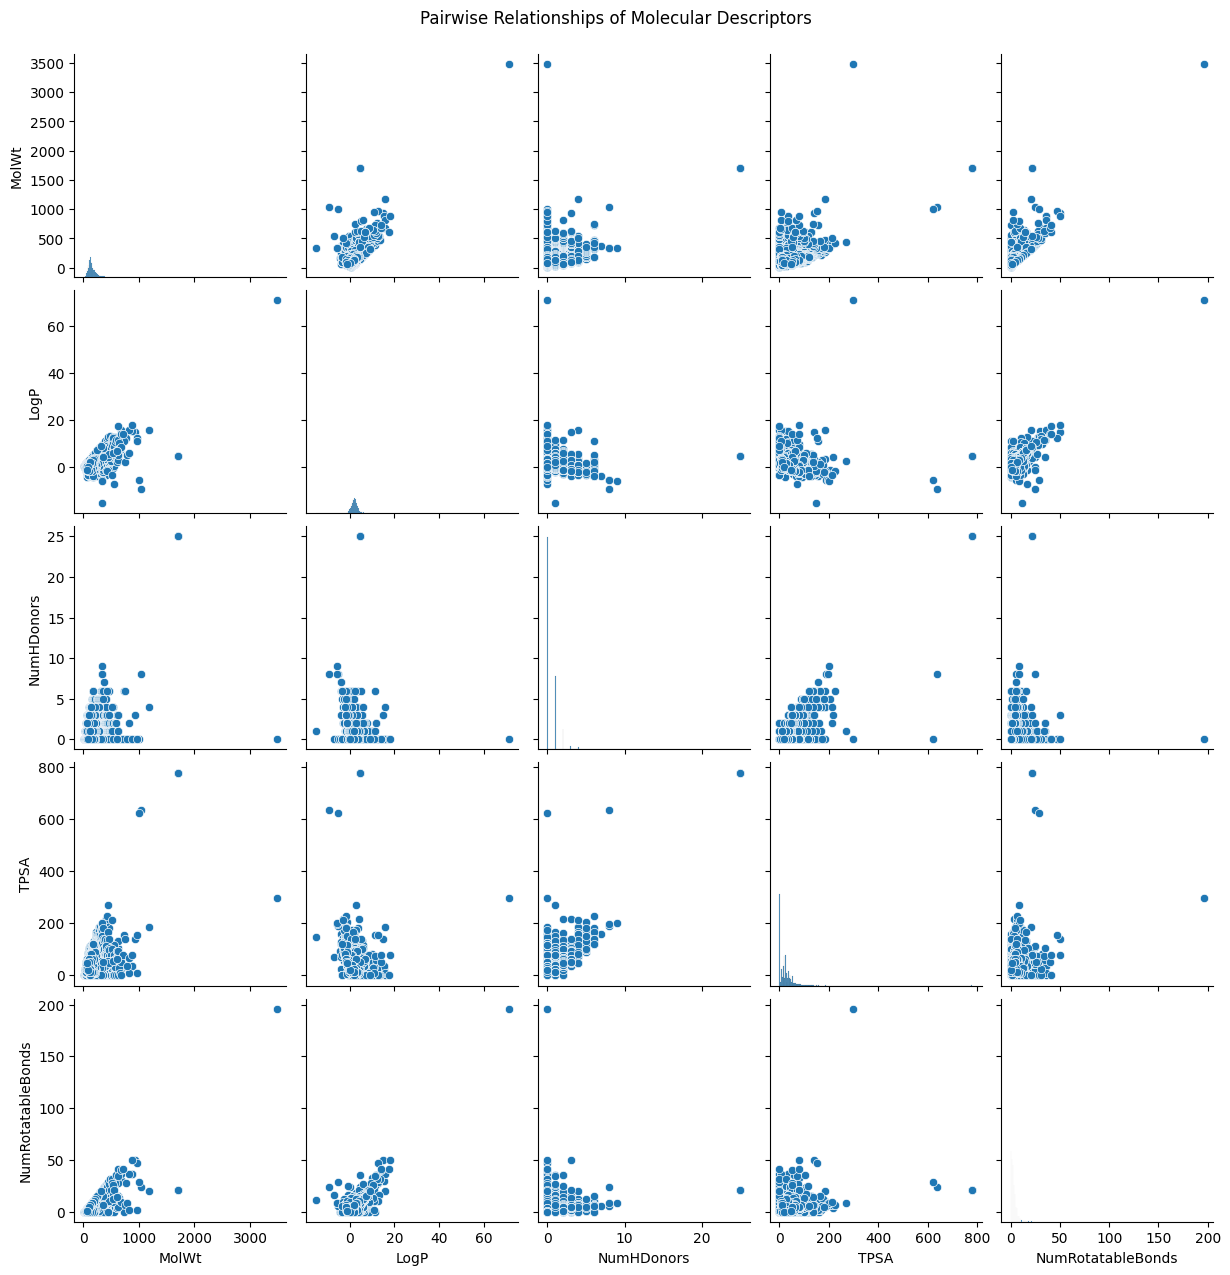

In [11]:
import seaborn as sns

# Select a subset of features to avoid clutter
subset_features = ['MolWt', 'LogP', 'NumHDonors', 'TPSA', 'NumRotatableBonds']
sns.pairplot(X[subset_features])
plt.suptitle("Pairwise Relationships of Molecular Descriptors", y=1.02)
plt.show()

**Correlation heatmap**

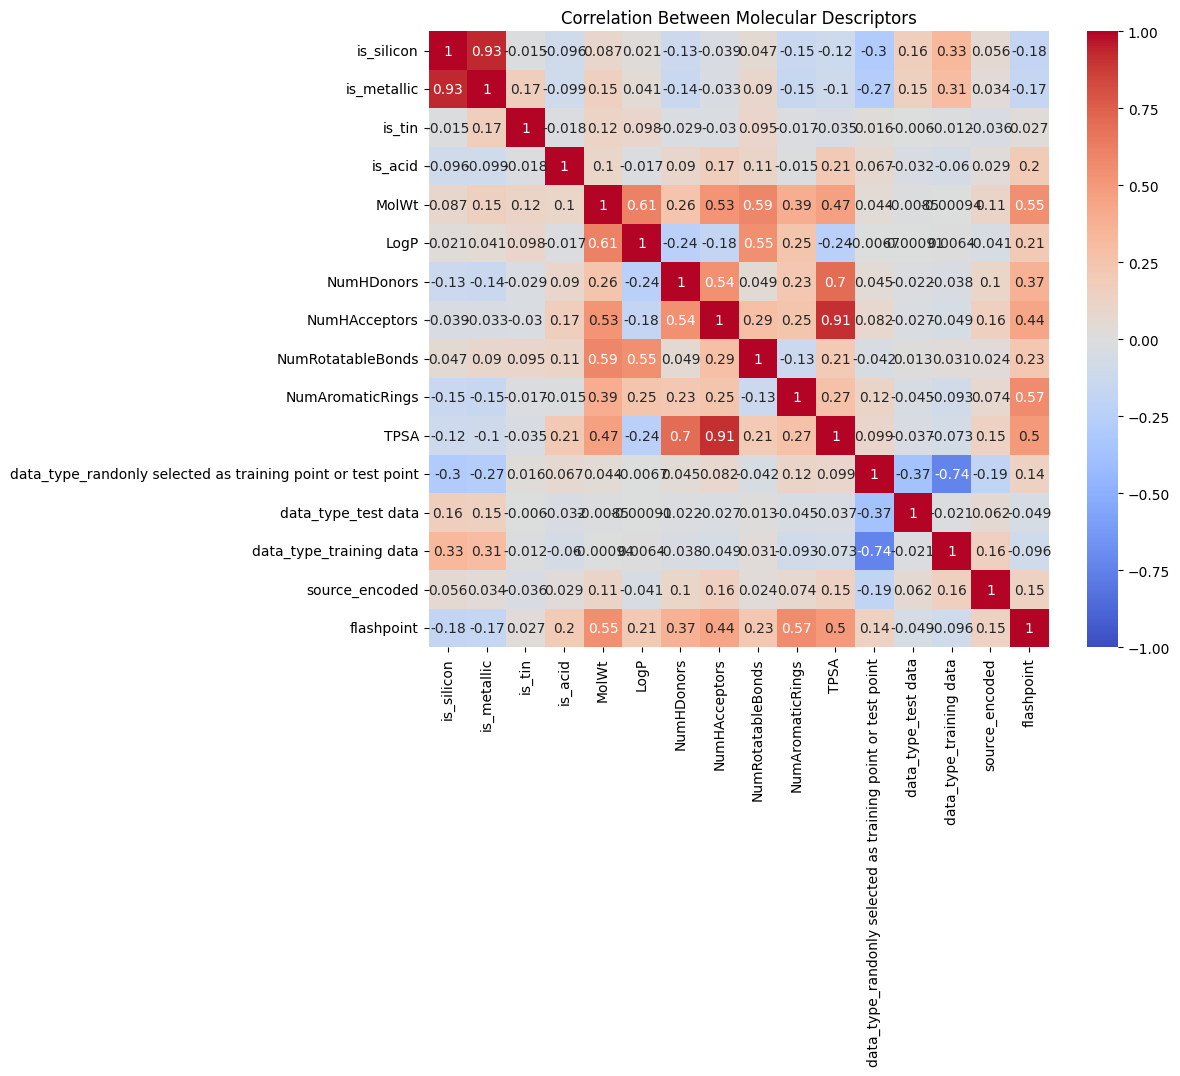

In [12]:
corr_matrix = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Molecular Descriptors")
plt.show()

Initial remark we notice that there is a relatively high correlation between the target and ['TPSA','NumAromaticRings','MolWt']